# 3D heat conduction over a 2D square domain
All edges constant temperature
```js
Works only on tf 1.x, 2.x and Pytorch
```
Backend supported: tensorflow.compat.v1, tensorflow, pytorch
 
 PDE: 
 
 $$u_{xx} + u_{yy} + u_{zz} = 0, \qquad x\in [-0.5,0.5], \quad y \in [-0.5,0.5] \quad z\in [0,1]$$
 
 $$u(x,y,0) = u(x,y,1) = 100 \quad u(-0.5,y,z) = 200 \quad u(0.5,y,z) = 100 \quad u(x,-0.5,z) = 200 \quad u(x,0.5,z) = 200$$

True solution

<img src="Exact.jpg" alt="Drawing" style="width: 600px;"/>

In [1]:
!pip install deepxde

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 120 kB 21.3 MB/s eta 0:00:01
     |████████████████████████████████| 100 kB 35.3 MB/s ta 0:00:01


* import packages
* define `dde.geometry.Interval` object for $x$.
* write a function for the residual.
* write a function to return boolean when `x` is a initial boundary point.
* Pass all the objects to `dde.data.PDE`
* define the neural network (architecture, activation, weight initialisation)
* build the model `dde.Model` by passing the data and network.
* initialise the optimiser
* train the model

For Pytorch: `nano ~/.deepxde/config.json`
then change `tensorflow.compat.v1` to `pytorch`


In [1]:
import deepxde as dde  # A complete problem: data+PDE+FCNN+optimiser
import numpy as np

Using backend: pytorch



In [3]:
#from deepxde.backend import torch # performs Pytorch operation on the dde object

In [29]:
# Parameters

#n=2
#precision_train = 10
#precision_test = 30
hard_constraint = False # set constraint type
weights = 100  # if hard_constraint == False

epochs = 60000
# learning rate, the number of dense layers and nodes, and the activation function
parameters = [1e-3, 10, 150, "tanh"]

# # Define sine function
# if dde.backend.backend_name == "pytorch":
#     sin = dde.backend.pytorch.sin
# else:
#     from deepxde.backend import tf

#     sin = tf.sin

learning_rate, num_dense_layers, num_dense_nodes, activation = parameters

In [30]:
def pde(X,u):
    """
    Returns the residual error

    Parameters
    ----------
    x : nd-array
        Independent variables.
    y : nd-array
        Dependent variables.

    Returns
    -------
    float
        The residual error.
    """ 
    dy_xx = dde.grad.hessian(u, X, i=0, j=0)
    dy_yy = dde.grad.hessian(u, X, i=1, j=1)
    dy_zz = dde.grad.hessian(u, X, i=2, j=2)
    #x = X[:, 0:1]
    #y = X[:, 1:2]
    #f = k0 ** 2 * sin(k0 * x) * sin(k0 * y)
    return dy_xx + dy_yy + dy_zz

# def boundary_r(x, on_boundary):
#     """
#     Defines the Periodic BC points (not the solution)
#     Returns 1 if x is on the boundary else 0.
#     because of rounding-off error we use np.isclose() to test whether two floating points are equivalent
#     """
#     return on_boundary
    
    
def boundary_left(X, on_boundary):
    """
    Defines the Dirichlet BC points (not the solution)
    The function should return `True` for those points inside the subdomain and `False` for the points outside.
    Returns 1 if x is on the boundary else 0.

    Parameters
    ----------
    x : 1d-array
        x,y,z coodinates of any point.

    Returns
    -------
    boolean
        whether x is on the boundary or not.
    """ 
    x = X[0]
    return on_boundary and np.isclose(x, 0) # when x= 0

def boundary_right(X, on_boundary):
    x = X[0] # # X[:, 0:1] is equivalent to X[:,0]
    return on_boundary and np.isclose(x, 1) # when x= 1

def boundary_bottom(X, on_boundary):
    y = X[1] # X[:, 1:2] is equivalent to X[:,1]
    return on_boundary and np.isclose(y, 0) # when y = 0

def boundary_top(X, on_boundary):
    y = X[1] # X[:, 1:2] is equivalent to X[:,1]
    return on_boundary and np.isclose(y, 1) # when y = 1

# def func_dirichlet(x):
#     """
#     Returns the prescribed Dirichlet boundary condition.
#     A wayaround is to use lambda function when specifying the BCs
#     Parameters
#     ----------
#     x : 1d-array
#         x,y,z coodinates of any point.
    
#     Returns
#     -------
#     float
#         the prescribed boundary condition at x.
    
#     Example
#     -------
#     If the function value is a constant
#     return 1
    
#     If the function value is not a constant
#         return np.sin(np.pi * x)
#     """ 
#     return 0


# def func_neumann(x):
#     """
#     Returns the prescribed Neumann boundary condition.
#     A wayaround is to use lambda function when specifying the BCs
#     Parameters
#     ----------
#     x : 1d-array
#         x,y,z coodinates of any point.
    
#     Returns
#     -------
#     float
#         the prescribed boundary condition at x.
    
#     Example
#     -------
#     If the function value is a constant
#     return 1
    
#     If the function value is not a constant
#         return np.sin(np.pi * x)
#     """ 
#     return 4 # see the problem

def exact(X):
    """
    Returns the exact solution
    Parameters
    ----------
    x : 1d-array
        x,y,z coodinates of any point.
    
    Returns
    -------
    float
        The exact solution.
    """ 
    #x = X[:, 0:1]
    #y = X[:, 1:2]
    # x[:,1:] and x[:,1:2] are the same for x of size [no_of_samples,2]
    
    return 0 # do not use tf.sin as this is just to plot the curve

If boundary conditions are enforced in a hard fashion, we apply the following transformation to the neural network:
$$\hat{u}(x,y) = x (x-1) y (y-1) \mathcal{N}(x,y)$$

In [13]:
# def transform(X, u): # transform the NN
#     x = X[:, 0:1]
#     y = X[:, 1:2]
#     res = x * (1 - x) * y * (1 - y)
#     return res * u

`dde.geometry.Rectangle` takes coordinates of bottom left and top right as input and creates a Rectangle.

We use a collocation points density of 10 (for test 30) points per wavelength for the training (resp. testing) data along each direction.

In [32]:
geom = dde.geometry.Cuboid(xmin=[-0.5,-0.5,0], xmax=[0.5,0.5,1]) # see the problem statement

# use lambda function to define the BC solution at each boundary
# The BCs are in same order as in the problem statement

bc_1 = dde.icbc.DirichletBC(geom, 
                               lambda x: 1, 
                               lambda x, on_boundary: on_boundary and np.isclose(x[2], 0)) # BC(boundary) 

bc_2 = dde.icbc.DirichletBC(geom, 
                               lambda x: 1, 
                               lambda x, on_boundary: on_boundary and np.isclose(x[2], 1)) # BC(boundary) 

bc_3 = dde.icbc.DirichletBC(geom, 
                               lambda x: 2, 
                               lambda x, on_boundary: on_boundary and np.isclose(x[0], -0.5)) # BC(boundary) 

bc_4 = dde.icbc.DirichletBC(geom, 
                               lambda x: 1, 
                               lambda x, on_boundary: on_boundary and np.isclose(x[0], 0.5)) # BC(boundary) 

bc_5 = dde.icbc.DirichletBC(geom, 
                               lambda x: 2, 
                               lambda x, on_boundary: on_boundary and np.isclose(x[1], -0.5)) # BC(boundary) 


bc_6 = dde.icbc.DirichletBC(geom, 
                               lambda x: 2, 
                               lambda x, on_boundary: on_boundary and np.isclose(x[1], 0.5)) # BC(boundary) 

# 1200: no. of collocation points
# 120: no. of BC points
# num_test: no residual points for testing
data = dde.data.PDE(
    geom,
    pde,
    [bc_1, bc_2, bc_3, bc_4, bc_5, bc_6],
    num_domain = 15000, # The balance properties of Sobol' points require n to be a power of 2. 0
    num_boundary = 5000, # the BC are prescribed on 3D domain so we have lot more points
    #solution = exact, # we don't know the exact solution
    #num_test = nx_test ** 2
)

The argument `solution=exact` is the reference solution to compute the error of our solution, 
and can be ignored if we don’t have a reference solution.

In [33]:
#layer_size = [2] + [20]*3 + [1] # [1, 50, 50, 50, 1]
#activation = "tanh"
#initialiser = "Glorot normal"
net = dde.nn.FNN(
    [3] + [num_dense_nodes] * num_dense_layers + [1],
    activation,
    "Glorot uniform"
) # creating a neural network

# Apply the feature transform
#net.apply_feature_transform(feature_transform)

When soft constraints are applied, we apply a weight to the boundary term to improve convergence for the ADAM optimizer.

In [34]:
# if hard_constraint == True: # transform the NN
#     net.apply_output_transform(transform)

model = dde.Model(data, net)  # defining the model

# if hard_constraint == True:
#     model.compile("adam", lr=learning_rate, metrics=["l2 relative error"])
# else:
#     loss_weights = [1, weights] # soft contraint
#     model.compile(
#         "adam",
#         lr=learning_rate,
#         metrics=["l2 relative error"],
#         loss_weights=loss_weights,)

model.compile("adam",
              lr=1e-3,
              #metrics=["l2 relative error"], # we don't have the testing dataset (true solution)
            ) # setting the optimiser

Compiling model...
'compile' took 0.000329 s



In [35]:
# Training with Adam
losshistory, train_state = model.train(epochs=15000, model_save_path="model/adam_model.ckpt")

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [1.14e-02, 1.00e+00, 6.74e-01, 3.66e+00, 8.13e-01, 3.44e+00, 3.84e+00]    [1.14e-02, 1.00e+00, 6.74e-01, 3.66e+00, 8.13e-01, 3.44e+00, 3.84e+00]    []  
1000      [2.46e-02, 1.90e-01, 1.81e-01, 5.76e-02, 2.39e-02, 2.67e-01, 2.49e-01]    [2.46e-02, 1.90e-01, 1.81e-01, 5.76e-02, 2.39e-02, 2.67e-01, 2.49e-01]    []  
2000      [1.71e-02, 3.04e-01, 2.70e-01, 3.36e-02, 1.84e-02, 2.31e-01, 2.09e-01]    [1.71e-02, 3.04e-01, 2.70e-01, 3.36e-02, 1.84e-02, 2.31e-01, 2.09e-01]    []  
3000      [7.63e-02, 9.50e-02, 9.52e-02, 6.78e-02, 7.05e-02, 1.03e-01, 1.05e-01]    [7.63e-02, 9.50e-02, 9.52e-02, 6.78e-02, 7.05e-02, 1.03e-01, 1.05e-01]    []  
4000      [2.26e-03, 2.67e-01, 2.36e-01, 2.29e-01, 2.29e-01, 2.59e-01, 2.42e-01]    [2.26e-03, 2.67e-01, 2.36e-01, 2.29e-01, 2.29e-01, 2.59e-01, 2.42e-01]    [

In [9]:
# Do not use l-bfgs
#model.compile("L-BFGS-B")
#losshistory, train_state = model.train(epochs=10000, model_save_path="model/lbfgs_model.ckpt")

In [29]:
# Optional: Save the model during training.
checkpointer = dde.callbacks.ModelCheckpoint(
    "model/model_new.cpkt", verbose=1, save_better_only=True
)


In [10]:
# save all the variables
model.save('model',protocol='backend', verbose=0)

'model-5000.pt'

In [ ]:
# Optional: Save the movie of the network solution during training.
# ImageMagick (https://imagemagick.org/) is required to generate the movie.
movie = dde.callbacks.MovieDumper(
    "model/movie", [-1], [1], period=100, save_spectrum=True, y_reference=func
)
losshistory, train_state = model.train(epochs=10000, callbacks=[checkpointer, movie])


Saving loss history to /lustrehome/home/s.1915438/deepxde_try/3D/3D deepxde/1. All constant temperature/loss.dat ...
Saving training data to /lustrehome/home/s.1915438/deepxde_try/3D/3D deepxde/1. All constant temperature/train.dat ...
Saving test data to /lustrehome/home/s.1915438/deepxde_try/3D/3D deepxde/1. All constant temperature/test.dat ...


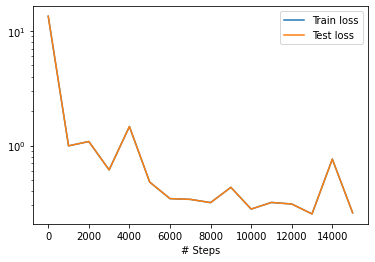

In [37]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

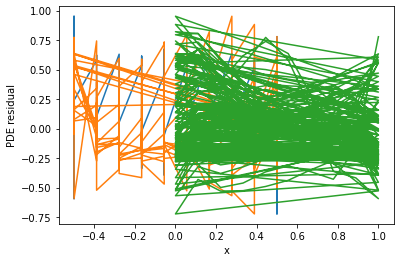

In [38]:
# Optional: Restore the saved model with the smallest training loss
# model.restore(f"model/model-{train_state.best_step}.ckpt", verbose=1)
# Plot PDE residual
import matplotlib.pyplot as plt
x = geom.uniform_points(1000, True)
y = model.predict(x, operator=pde)
plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("PDE residual")
plt.show()

In [39]:
# Custom plot
# Link: https://github.com/lululxvi/deepxde/issues/17
# In test.dat, the first column is x coordinate, the second column is y coordinate, the 3rd column is y_true, the 4th column is y_pred.
import numpy as np
data = np.genfromtxt('test.dat')

In [40]:
x, y, z, y_pred = data[:,0], data[:,1], data[:,2], data[:,3]

In [41]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [42]:
losshistory.steps[-1]

15000

/tmp/ipykernel_44033/1640105220.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  sc1.cmap.set_under('k')
/tmp/ipykernel_44033/1640105220.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  sc1.cmap.set_over('k')


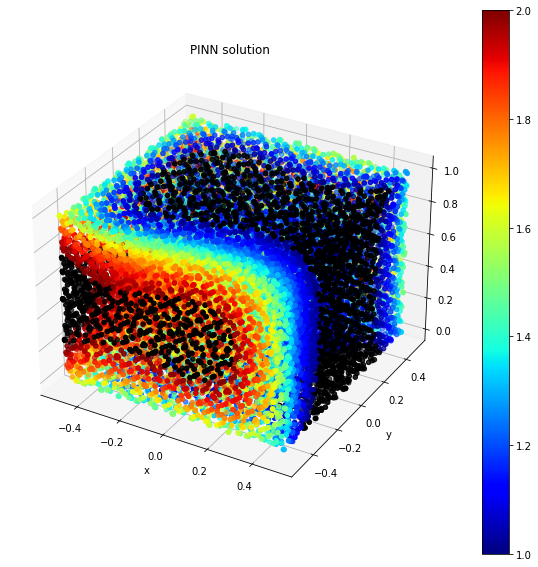

In [43]:

#plt.figure(1,figsize=(12,10))
fig, ax = plt.subplots(1,figsize=(10,10),subplot_kw=dict(projection='3d'))
sc1 = ax.scatter(x,y,z, c = y_pred, cmap=cm.jet, vmin=1, vmax=2)
sc1.cmap.set_under('k')
sc1.cmap.set_over('k')
ax.set_title('PINN solution')
#ax.set_aspect('equal', 'box')
# sc2 = ax[1].scatter(x,y, c = y_pred, cmap=cm.jet)
# ax[1].set_title('Predicted Solution')
# ax[1].set_aspect('equal', 'box')
# sc3 = ax[2].scatter(x,y, c = abs(y_pred-y_true), cmap=cm.jet)
# ax[2].set_title('Absolute pointwise error')
# ax[2].set_aspect('equal', 'box')


#for axs in ax.flat:
ax.set(xlabel='x', ylabel='y')
fig.colorbar(sc1, ax=ax)
#fig.colorbar(sc2, ax=ax[1])
#fig.colorbar(sc3, ax=ax[2])
plt.savefig(str(losshistory.steps[-1])+'_epoch.jpg', dpi = 200)

Because we only use 8k residual points for training, the accuracy is low. Next, we improve the accuracy by the residual-based adaptive refinement (RAR) method. Because the Burgers equation has a sharp front, intuitively, we should put more points near the sharp front. First, we randomly generate 100000 points from our domain to calculate the PDE residual.


In [18]:
X = geom.random_points(100000)
err = 1


We will repeatedly add points while the mean residual is greater than 0.005. Each iteration, we use our model to generate predictions for inputs in X and compute the absolute values of the errors. We then print the mean residual. Next, we find the points where the residual is greatest and add these new points for training PDE loss. Furthermore, we define a callback function to check whether the network converges. If there is significant improvement in the model's accuracy, as judged by the callback function, we continue to train the model. As before, after we train the network using Adam, we continue to train the network using L-BFGS to achieve a smaller loss:

In [19]:
while err > 0.005:
    f = model.predict(X, operator=pde)
    err_eq = np.absolute(f)
    err = np.mean(err_eq)
    print("Mean residual: %.3e" % (err))

    x_id = np.argmax(err_eq)
    print("Adding new point:", X[x_id], "\n")
    data.add_anchors(X[x_id])
    early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)
    model.compile("adam", lr=1e-3)
    model.train(epochs=10000, disregard_previous_best=True, callbacks=[early_stopping])
    model.compile("L-BFGS")
    losshistory, train_state = model.train()

Mean residual: 7.749e+00
Adding new point: [0.11394322 0.48531592 0.9902613 ] 



AttributeError: 'numpy.ndarray' object has no attribute 'add_anchors'

In [ ]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

X, y_true = gen_testdata()
y_pred = model.predict(X)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))